# Test many dither patterns#

This notebook is intended to demonstrate the various 'stock' dithering patterns available through MAF and then show how to use these dithering patterns to evaluate metrics under different dithering schemes.

This also provides an extended example of MAF [`Stackers`](https://confluence.lsstcorp.org/display/SIM/MAF+Stackers) which allow the addition of 'virtual' columns to the Opsim data, by generating these additional columns on the fly. 

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.db as db
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots

---

# Demonstrate the dithering patterns#

Here is an overview of the available dithering patterns. First - a list of the 'stock' dithering patterns available from MAF, along with their docstrings.

In [2]:
# Grab all the dither stackers from the stock stackers (rather than all stackers)
import inspect
ditherStackerList = []
for name, s in inspect.getmembers(stackers):
    if inspect.isclass(s):
        if 'Dither' in s.__name__:
            ditherStackerList.append(s)

In [3]:
# Print their docstrings
for s in ditherStackerList:
    print('-- ', s.__name__, ' --')
    print('\n'.join(s.__doc__.splitlines()[1:4]))
    print('    Generates columns named', s().colsAdded)
    print(' ')

--  DefaultDitherStacker  --
    Make a default dither pattern to stack on ditheredRA and ditheredDec.
    The default pattern is HexDitherPerNightStacker.

    Generates columns named ['ditheredRA', 'ditheredDec']
 
--  HexDitherFieldPerNightStacker  --
    Use offsets from the hexagonal grid of 'hexdither', but visit each vertex sequentially.
    Sequential offset for each night of visits.

    Generates columns named ['hexDitherFieldPerNightRa', 'hexDitherFieldPerNightDec']
 
--  HexDitherFieldPerVisitStacker  --
    Use offsets from the hexagonal grid of 'hexdither', but visit each vertex sequentially.
    Sequential offset for each visit.

    Generates columns named ['hexDitherFieldPerVisitRa', 'hexDitherFieldPerVisitDec']
 
--  HexDitherPerNightStacker  --
    Use offsets from the hexagonal grid of 'hexdither', but visit each vertex sequentially.
    Sequential offset per night for all fields.

    Generates columns named ['hexDitherPerNightRa', 'hexDitherPerNightDec']
 
--  Ran

Note that the 'nightly' versions of the stackers apply the same dither to all observations of a particular field taken in a single night (but may vary from one field to the next), while the versions without 'nightly' apply a separate dither offset to each visit.

**Visualize the dither options:**
Just write a bit of code to make nice figures of the dithering patterns.

In [4]:
import numpy as np

In [5]:
def plotDither(ditherStacker, nvisits=1000, addPolygon=True):
    # Set up some 'data' on a single pointing to dither
    fieldIds = np.ones(nvisits, int)
    fieldRA = np.zeros(nvisits, float) + 10.0
    fieldDec = np.zeros(nvisits, float)
    night = np.arange(0, nvisits/2.0, 0.5)
    night = np.floor(night)
    simdata = np.core.records.fromarrays(
        [fieldIds, fieldRA, fieldDec, night],
        names=['fieldId', 'fieldRA', 'fieldDec', 'night'])

    # Apply the stacker.
    simdata = ditherStacker.run(simdata)

    fig = plt.figure()
    plt.axis('equal')
    # Draw a point for the center of the FOV.
    x = simdata['fieldRA'][0]
    y = simdata['fieldDec'][0]
    plt.plot(x, y, 'g+')
    # Draw a circle approximately the size of the FOV.
    stepsize = np.pi/50.
    theta = np.arange(0, np.pi*2.+stepsize, stepsize)
    radius = 1.75
    plt.plot(radius*np.cos(theta)+x, radius*np.sin(theta)+y, 'g-')
    # Add the inscribed hexagon
    nside = 6
    a = np.arange(0, nside)
    xCoords = np.sin(2*np.pi/float(nside)*a + np.pi/2.0)*radius + x
    yCoords = np.cos(2*np.pi/float(nside)*a + np.pi/2.0)*radius + y
    xCoords = np.concatenate([xCoords, np.array([xCoords[0]])])
    yCoords = np.concatenate([yCoords, np.array([yCoords[0]])])
    plt.plot(xCoords, yCoords, 'b-')
    # Draw the dithered pointings.
    x = simdata[s.colsAdded[0]]
    y = simdata[s.colsAdded[1]]
    plt.plot(x, y, 'k-', alpha=0.2)
    plt.plot(x, y, 'r.')
    plt.title(s.__class__.__name__)

Look at the default dither patterns. Note that we skip the `RandomRotDitherPerFilterChangeStacker` because this changes the rotator angle of the camera, rather than a translation of the fov.

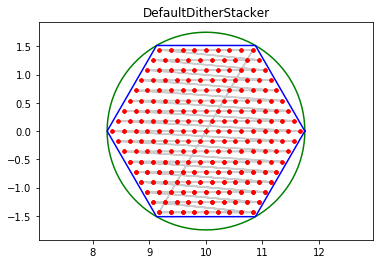

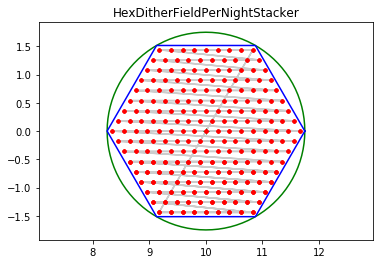

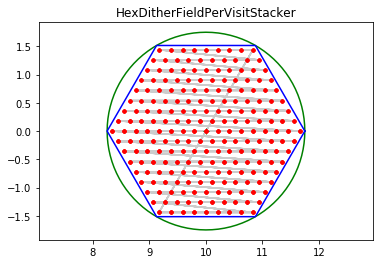

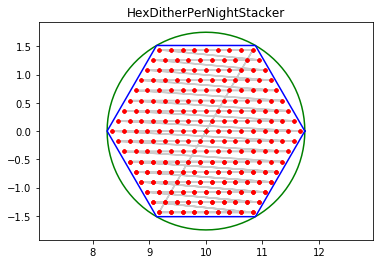

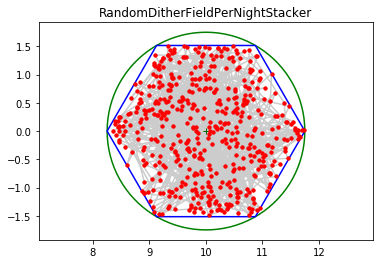

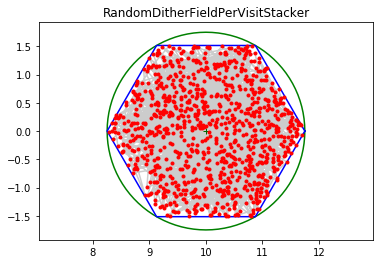

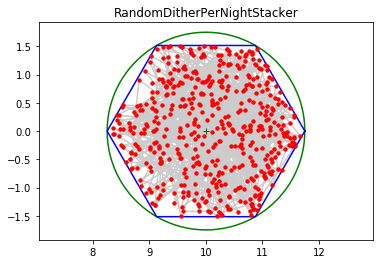

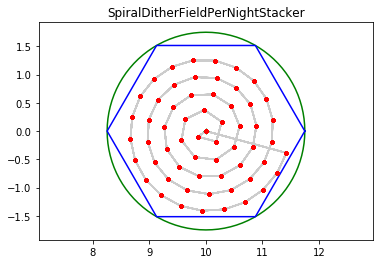

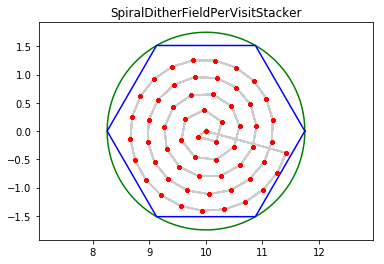

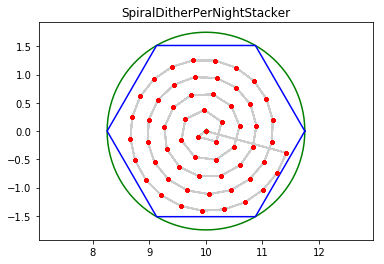

In [6]:
for i, ditherStacker in enumerate(ditherStackerList):
    # Skip the RandomRotDitherPerFilterChangeStacker
    if ditherStacker.__name__ == 'RandomRotDitherPerFilterChangeStacker':
        continue
    s = ditherStacker()
    plotDither(s)

Example comparison of spiral dither with one offset applied per field per night vs one offset per field per visit (the timescale on which the dithers are applied is different). 

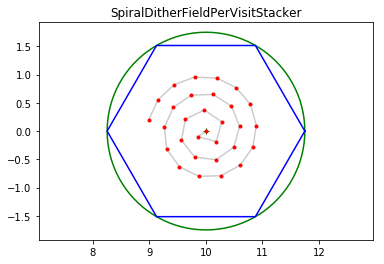

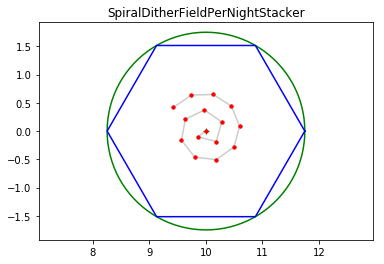

In [7]:
s = stackers.SpiralDitherFieldPerVisitStacker()
plotDither(s, nvisits=30)
s = stackers.SpiralDitherFieldPerNightStacker()
plotDither(s, nvisits=30)

Look at the dither patterns after some additional configuration (such as setting the random seed or changing the maxDither or allowing the points to wander outside the inscribed hexagon). 

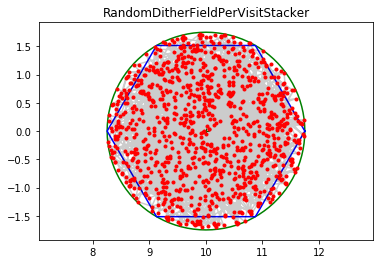

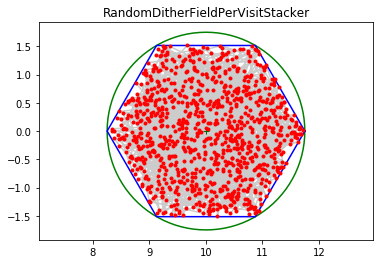

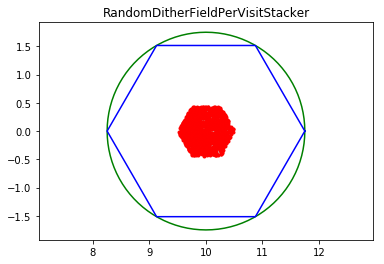

In [8]:
# inHex is true by default
s = stackers.RandomDitherFieldPerVisitStacker(maxDither=1.75, inHex=False)
plotDither(s)
s = stackers.RandomDitherFieldPerVisitStacker(maxDither=1.75, inHex=True)
plotDither(s)
s = stackers.RandomDitherFieldPerVisitStacker(maxDither=0.5)
plotDither(s)

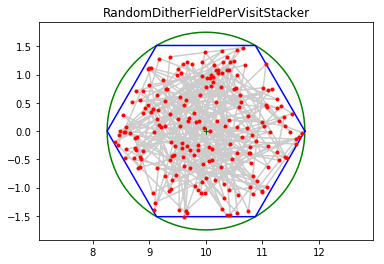

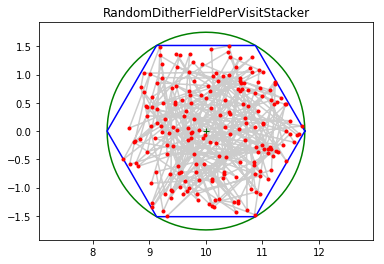

In [9]:
s = stackers.RandomDitherFieldPerVisitStacker(randomSeed=253)
plotDither(s, nvisits=200)
s = stackers.RandomDitherFieldPerVisitStacker(randomSeed=100)
plotDither(s, nvisits=200)

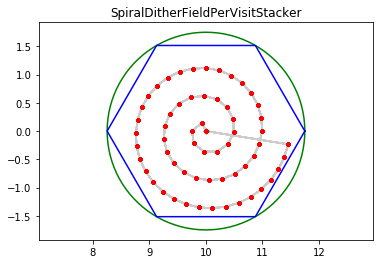

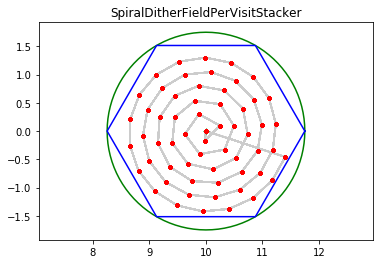

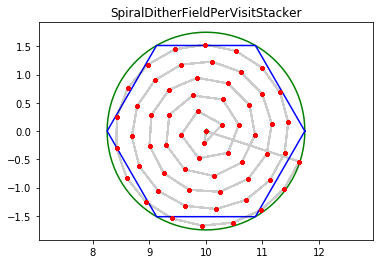

In [10]:
s = stackers.SpiralDitherFieldPerVisitStacker(nCoils=3)
plotDither(s)
s = stackers.SpiralDitherFieldPerVisitStacker(nCoils=6)
plotDither(s)
s = stackers.SpiralDitherFieldPerVisitStacker(nCoils=6, inHex=False)
plotDither(s)

---
# Using the dither stackers #

We'll set up with a very simple metricbundle to just count the number of visits at each RA/Dec point in a healpix grid. To extend this to your own work, you could simply swap the metric to something more relevant. To speed up the notebook, run this example with a smaller nside (64?) to use a slightly lower resolution for the healpix slicer and only look at the first two years of visits. 

First, a metricbundle with no dithering.

In [11]:
runName = 'baseline2018a'

opsdb = db.OpsimDatabase(runName + '.db')

mjdcol = 'observationStartMJD'
degrees = True
fieldIdCol = 'fieldId'

nside = 128
metric = metrics.CountMetric(mjdcol, metricName='N_visits')
slicer0 = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec', 
                                nside=nside, latLonDeg=degrees)  
sqlconstraint = 'filter="r"'

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [12]:
myBundles = {}
myBundles['no dither'] = metricBundles.MetricBundle(
    metric, slicer0, sqlconstraint, runName=runName, metadata='no dither')

Next, a metricBundle using the built-in opsim hex-dither dithering. This dither pattern looks like the 'sequential dither pattern' above, but each offset is applied to *all* visits during a night (for all fields). The sequence along the vertices is controlled by the night %217 (the number of vertices), so some fields may never be offset at a particular vertex.

To use a different dither pattern to evaluate our metric, we simply change the values of ra/dec that the slicer is using to match visits to healpix grid points. 

In [13]:
# ditheredRA and ditheredDec correspond to the stock opsim dither pattern
stacker1 = stackers.DefaultDitherStacker(fieldIdCol=fieldIdCol, degrees=degrees)
slicer1 = slicers.HealpixSlicer(lonCol='ditheredRA', latCol='ditheredDec', 
                                latLonDeg=degrees, nside=nside)
myBundles['hex dither'] = metricBundles.MetricBundle(
    metric, slicer1, sqlconstraint, runName=runName, 
    metadata='hex dither', stackerList=[stacker1])

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


If we want to use a stacker in its 'default' state, we can let MAF handle this internally, and we don't have to explicitly instantiate our stacker. We do have to use the exact column names that each stacker adds to the simData output (which you can see in the list of stackers and their docstrings, above). 

Note that the default state is set up to match opsim v4 output -- angles are assumed to be in degrees and the database columns must match v4 column names. If you want to use v3 or other non-standard output, please be sure to explicitly instantiate each stacker.

In [14]:
# baseline2018a is a v4 database, so we're cool to use the defaults.
slicer2 = slicers.HealpixSlicer(lonCol='randomDitherFieldPerVisitRa', 
                                latCol='randomDitherFieldPerVisitDec', 
                                latLonDeg=degrees, nside=nside)
myBundles['random dither'] = metricBundles.MetricBundle(
    metric, slicer2, sqlconstraint, runName=runName, metadata='random dither')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


On the other hand, if we want to customize a stacker, we must explicitly instantiate it and pass it to the metricBundle.

In [15]:
stacker3 = stackers.SpiralDitherFieldPerNightStacker(
    nCoils=7, fieldIdCol=fieldIdCol, degrees=degrees)
slicer3 = slicers.HealpixSlicer(lonCol='spiralDitherFieldPerNightRa', 
                                latCol='spiralDitherFieldPerNightDec', 
                                latLonDeg=degrees, nside=nside)
myBundles['spiral dither'] = metricBundles.MetricBundle(
    metric, slicer3, sqlconstraint, stackerList=[stacker3], 
    runName=runName, metadata='spiral dither')

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Now, as before, we run this dictionary of metricBundles, using the MetricBundleGroup (note the sqlconstraint is the same for all these bundles). 

In [16]:
outDir = 'dither_test'
resultsDb = db.ResultsDb(outDir=outDir)
bgroup = metricBundles.MetricBundleGroup(myBundles, opsdb, outDir=outDir, 
                                         resultsDb=resultsDb)

(If we had previously calculated these metrics, but wanted to read them back in here to regenerate the plots, we'd do something like the next cell.)

In [17]:
previously_calculated = False
if previously_calculated:
    import os
    for b in bgroup.bundleDict.values():
        filename = os.path.join(outDir, b.fileRoot) + '.npz'
        b.read(filename)

In [18]:
bgroup.runAll()

Querying database SummaryAllProps with constraint filter="r" for columns ['fieldRA', 'observationStartMJD', 'night', 'fieldId', 'fieldDec']
Found 515172 visits
Running:  ['no dither']
Completed metric generation.
Running:  ['hex dither']
Completed metric generation.
Running:  ['random dither']
Completed metric generation.
Running:  ['spiral dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


We could just plot the individual skymap/histogram/power spectrum plots using bgroup.plotAll(), but here we'd prefer to get the individual skymaps, then a histogram and power spectrum using all the different metricBundles together.  In order to do that, we'll use the `PlotHandler` directly.

In [19]:
ph = plots.PlotHandler(outDir=outDir, resultsDb=resultsDb)

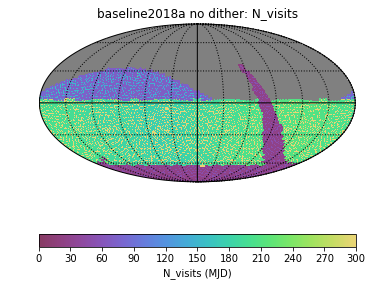

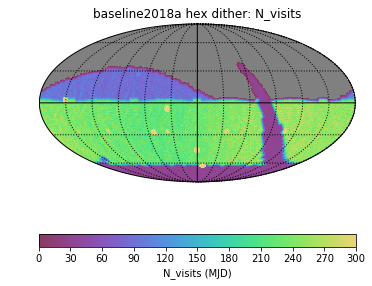

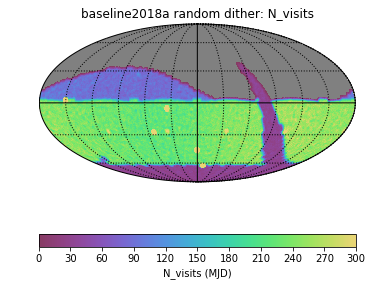

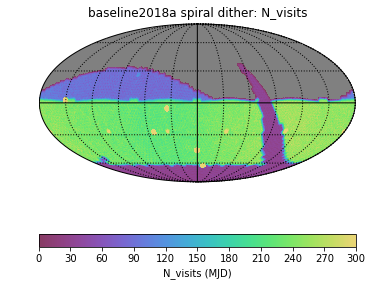

In [20]:
for mB in myBundles:
    plotDict = {'xMin':0, 'xMax':300, 'colorMin':0, 'colorMax':300}
    myBundles[mB].setPlotDict(plotDict)
    myBundles[mB].plot(plotFunc=plots.HealpixSkyMap, plotHandler=ph)

1

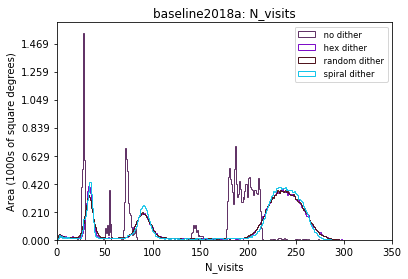

In [21]:
ph.setMetricBundles(myBundles)
# We must set a series of plotDicts: one per metricBundle. 
#  because we don't explicitly set the colors, they will be set randomly. 
plotDict = {'binsize':1, 'xMin':0, 'xMax':350}
ph.plot(plots.HealpixHistogram(), plotDicts=plotDict)

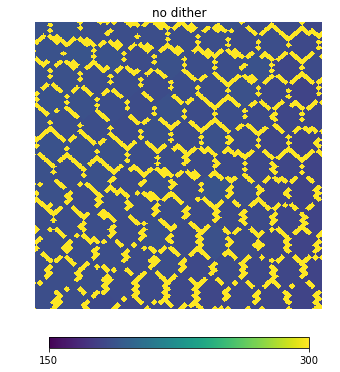

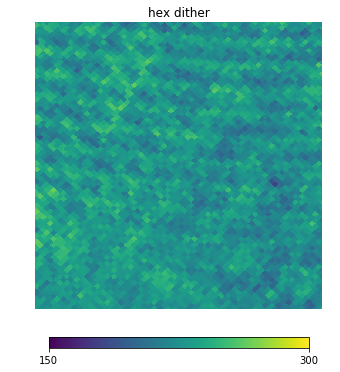

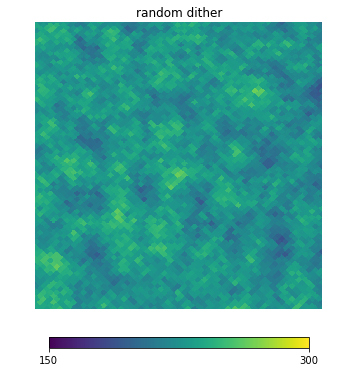

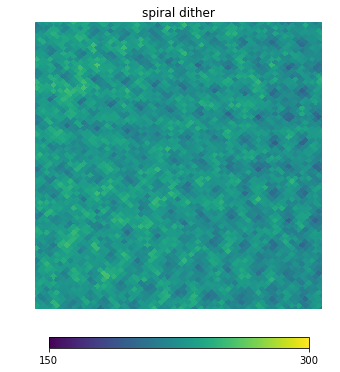

In [22]:
# Plot some close-ups.
import healpy as hp
for mB in myBundles.values():
    hp.cartview(mB.metricValues, lonra=[70, 100], latra=[-30, -0], 
                min=150., max=300., flip='astro', title=mB.metadata)

For some purposes, examining the angular power spectra (and the power in the power spectra) is important. In practice, this likely requires some masking of the metric data (to remove ringing near the edges of the dithering and from the lower number of visits/depth from the areas in the survey outside the WFD region). But, after this masking is done (see the science notebook [GalaxyCounts](../science/static/GalaxyCounts.ipynb) as an example), generating plots of the power spectra labelled with total power could be done as follows.

In [23]:
summaryMetrics = [metrics.TotalPowerMetric()]
for mB in myBundles.values():
    mB.setSummaryMetrics(summaryMetrics)
    mB.computeSummaryStats()
    plotDict = {
        'label': '%s : %g' % (mB.metadata, mB.summaryValues['TotalPower'])}
    mB.setPlotDict(plotDict)

monopole: 182.664  dipole: lon: -105.487, lat: -79.6086, amp: 21.7567
monopole: 170.927  dipole: lon: 99.5762, lat: -86.1103, amp: 40.9997
monopole: 170.974  dipole: lon: 104.242, lat: -86.0775, amp: 40.3787
monopole: 173.325  dipole: lon: 105.303, lat: -87.6464, amp: 36.5592


1

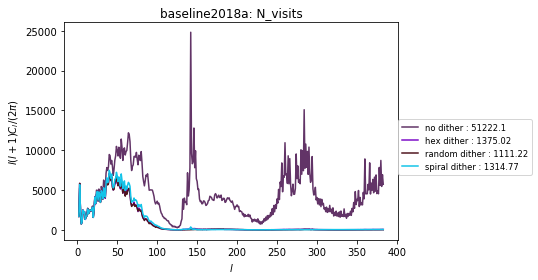

In [24]:
ph.plot(plots.HealpixPowerSpectrum(),
        plotDicts={'legendloc': (1, 0.3), 'xMin': 0})